In [ ]:
import pyiaea
from ROOT import *
from iaea.utils import Reader
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
from scipy.stats import norm, rankdata

# Klasa do rysowania histogramów w bibliotece ROOT

In [ ]:
class Histograms:
  def __init__(self,data):
    self.data = data

  def get_hist(self, col, n=1000):   # stworzenie histogramów domyślnie na 1000 binów z mozliwoscia zmiany
    hist0 = TH1D('h',col,n,self.data[col].min(),self.data[col].max())
    for index, row in self.data.iterrows():
      hist0.Fill(row[col])
    return hist0

  def min_col(self,col):    # min i max do rysowania histogramów potrzebne
    return min(self.data[col])

  def max_col(self,col):
    return max(self.data[col])

In [ ]:
Model = TFile.Open("/home/dawid/IAEA/model.root")

In [ ]:
X = Model.X
Y = Model.Y
W = Model.W
U = Model.U
V = Model.V
E = Model.E
cor = Model.correlate

In [ ]:
def correlate_matrix(cor):
  cols =  ["X", "Y","E","U","V", "W"] 
  cor_mat = [[ 0 for _ in range(6)] for _ in range(6)] 
  for i in range(6):
    for j in range(6):
      cor_mat[i][j] =  cor[i][j]
  cor_mat = pd.DataFrame(data  = cor_mat , columns=cols)
  return cor_mat

In [ ]:
cormatrix = correlate_matrix(cor)

# Macierz korelacji, która przechowuje model i która będzie odtwarzana

In [ ]:
cormatrix

,X,Y,E,U,V,W
0,1.000000,-0.000494,0.000452,0.980942,-0.000622,-0.000688
1,-0.000494,1.000000,0.002289,-0.000299,0.979913,0.049957
2,0.000452,0.002289,1.000000,0.000527,0.002280,0.113001
3,0.980942,-0.000299,0.000527,1.000000,-0.000368,-0.000483
4,-0.000622,0.979913,0.002280,-0.000368,1.000000,0.048524
5,-0.000688,0.049957,0.113001,-0.000483,0.048524,1.000000


# Losowanie parametrów statystycznych fotonów

In [ ]:
X1 = [] 
Y1 = []
E1=[]
U1=[]
V1=[]
W1=[]

for i in range(500000): 
    X1.append(X.GetRandom()) 
    Y1.append(Y.GetRandom())  
    E1.append(E.GetRandom()) 
    U1.append(U.GetRandom())
    V1.append(V.GetRandom())
    W1.append(W.GetRandom())

Warning in <TF1::GetRandom>: function:total has 6 negative values: abs assumed


In [ ]:
cols =  ["X", "Y","E","U","V", "W"] 
df = np.vstack((X1, Y1, E1, U1, V1, W1))
df = pd.DataFrame(data  = df.T , columns=cols)

# Macierz korelacji wylosowanych danych ( zgodnie z oczekiwaniami korelacji wynoszą 0)

In [ ]:
df.corr(method='spearman').style.background_gradient(cmap='coolwarm').set_precision(4) 

/tmp/ipykernel_1012/3839827691.py:1: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  df.corr(method='spearman').style.background_gradient(cmap='coolwarm').set_precision(4)


,X,Y,E,U,V,W
X,1.0000,-0.0000,0.0007,-0.0009,-0.0029,-0.0010
Y,-0.0000,1.0000,-0.0008,0.0017,0.0023,-0.0003
E,0.0007,-0.0008,1.0000,0.0016,0.0035,0.0000
U,-0.0009,0.0017,0.0016,1.0000,-0.0012,-0.0003
V,-0.0029,0.0023,0.0035,-0.0012,1.0000,-0.0005
W,-0.0010,-0.0003,0.0000,-0.0003,-0.0005,1.0000


Warning in <TFile::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: cs


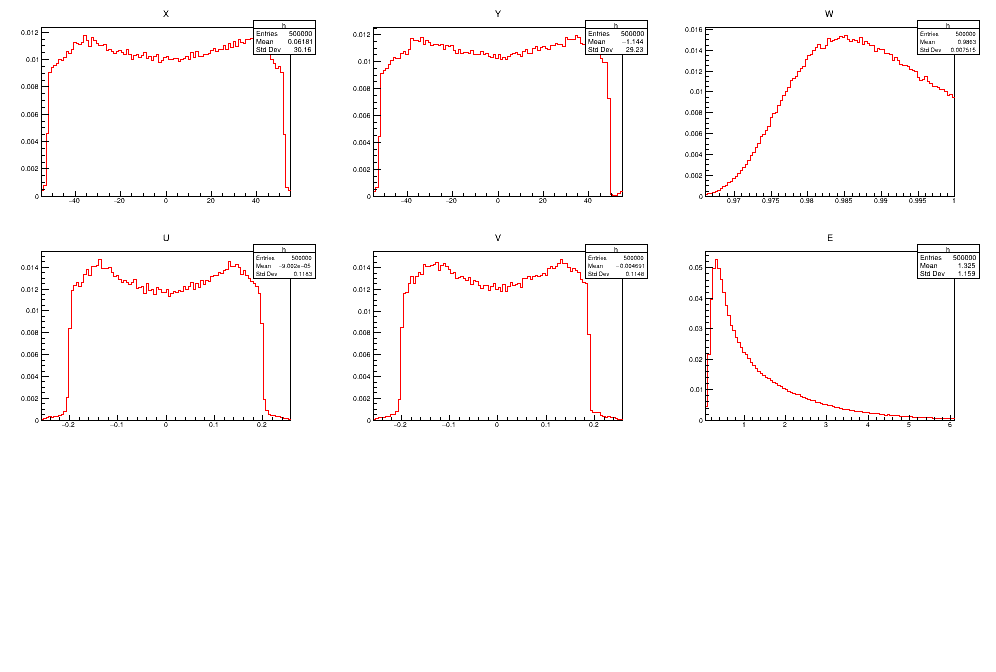

In [ ]:
histX1 =  TH1D('h',"X",100, -55,55)
histY1 = TH1D('h',"Y",100, -55,55)
histW1 =  TH1D('h',"W",100, df["W"].min(),df["W"].max())
histU1 = TH1D('h',"U",100, df["U"].min(), df["U"].max())
histV1 =  TH1D('h',"V",100, df["V"].min(), df["V"].max())
histE1 = TH1D('h',"E",100,df["E"].min(), df["E"].max())

for index, row in df.iterrows():
  histX1.Fill(row["X"])
  histY1.Fill(row["Y"])
  histW1.Fill(row["W"])
  histU1.Fill(row["U"])
  histV1.Fill(row["V"])
  histE1.Fill(row["E"])

cs = TCanvas("cs","cs",10,10,1000,700)
cs.Divide(3,3)
cs.cd(1)
histX1.DrawNormalized().SetLineColor(2)
cs.cd(2)
histY1.DrawNormalized().SetLineColor(2)
cs.cd(3)
histW1.DrawNormalized().SetLineColor(2)
cs.cd(4)
histU1.DrawNormalized().SetLineColor(2)
cs.cd(5)
histV1.DrawNormalized().SetLineColor(2)
cs.cd(6)
histE1.DrawNormalized().SetLineColor(2)

cs.Draw()

In [ ]:
def imanConover(data, corrmat,
                        cols = ["X", "Y","E","U","V", "W"]):
    X = data.to_numpy()
    X_rank = np.vstack([rankdata(datai, method="ordinal")
                                for datai in X.T]).T
    size = len(X_rank)
    X_rank_score = X_rank / (size + 1)
    X_rank_score = norm(0, 1).ppf(X_rank_score)
    P = np.linalg.cholesky(corrmat)
    corr_mat_X_rank = np.corrcoef(X_rank_score, rowvar=0)
    Q = np.linalg.cholesky(corr_mat_X_rank)
    Y = np.dot(P, np.linalg.inv(Q))
    new_data = np.dot(X_rank_score, Y.T)
    new_data_rank = np.vstack([rankdata(datai,
                                method="ordinal") 
                                for datai in new_data.T]).T
    new = new_data_rank.copy()
    new = np.float64(new)
    for i in range(len(cols)):
      X = sorted(X, key=lambda x: x[i], reverse = False)
      new = sorted(new, key=lambda x: x[i], reverse = False)
      for j in range(size):
          new[j][i] = X[j][i]
    new = pd.DataFrame(data  = new , columns=cols)
    indexes = list(new.index)
    random.shuffle(indexes)
    new_shuffled = new.loc[indexes]
    new_shuffled = new_shuffled.reset_index()
    new_shuffled = new_shuffled[cols]
    return new_shuffled



cor = cormatrix.to_numpy()
rand_cor = imanConover(rand[cols],cor)
rand_cor= pd.DataFrame(data  = rand_cor , columns=cols)


#MACIERZ KORELACJI PO TRANSFORMACJI, DLA PORÓWNANIA NIŻEJ POCZATKOWA MACIERZ, DLA DANYCH WEJŚCIOWYCH

In [ ]:
rand_cor.corr(method='spearman').style.background_gradient(cmap='coolwarm').set_precision(4) 

/tmp/ipykernel_1012/3036591634.py:1: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  rand_cor.corr(method='spearman').style.background_gradient(cmap='coolwarm').set_precision(4)


,X,Y,E,U,V,W
X,1.0000,-0.0007,0.0001,0.9791,-0.0008,-0.0008
Y,-0.0007,1.0000,0.0012,-0.0007,0.9780,0.0468
E,0.0001,0.0012,1.0000,0.0003,0.0014,0.1069
U,0.9791,-0.0007,0.0003,1.0000,-0.0007,-0.0005
V,-0.0008,0.9780,0.0014,-0.0007,1.0000,0.0453
W,-0.0008,0.0468,0.1069,-0.0005,0.0453,1.0000


#Porównanie histogramów przed i po trasformacji. Histogramy idealnie nachodzą na siebie zgodnie z oczekiwaniami algorytmu Imana Conovera, który nie powinien ingerować w wartości.



In [ ]:
#granice musza zosta z df poczatkwoego zeby szerokosc binow sie zgodzila
histX2 =  TH1D('h',"X",100, -55,55)
histY2 = TH1D('h',"Y",100, -55,55)
histW2 =  TH1D('h',"W",100, df["W"].min(),df["W"].max())
histU2 = TH1D('h',"U",100, df["U"].min(), df["U"].max())
histV2 =  TH1D('h',"V",100, df["V"].min(), df["V"].max())
histE2 = TH1D('h',"E",100,df["E"].min(), df["E"].max())

for index, row in df.iterrows():
  histX1.Fill(row["X"])
  histY1.Fill(row["Y"])
  histW1.Fill(row["W"])
  histU1.Fill(row["U"])
  histV1.Fill(row["V"])
  histE1.Fill(row["E"])

for index, row in rand_cor.iterrows():
  histX2.Fill(row["X"])
  histY2.Fill(row["Y"])
  histW2.Fill(row["W"])
  histU2.Fill(row["U"])
  histV2.Fill(row["V"])
  histE2.Fill(row["E"])


Warning in <TFile::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h (Potential memory leak).


Warning in <TCanvas::Constructor>: Deleting canvas with same name: cs


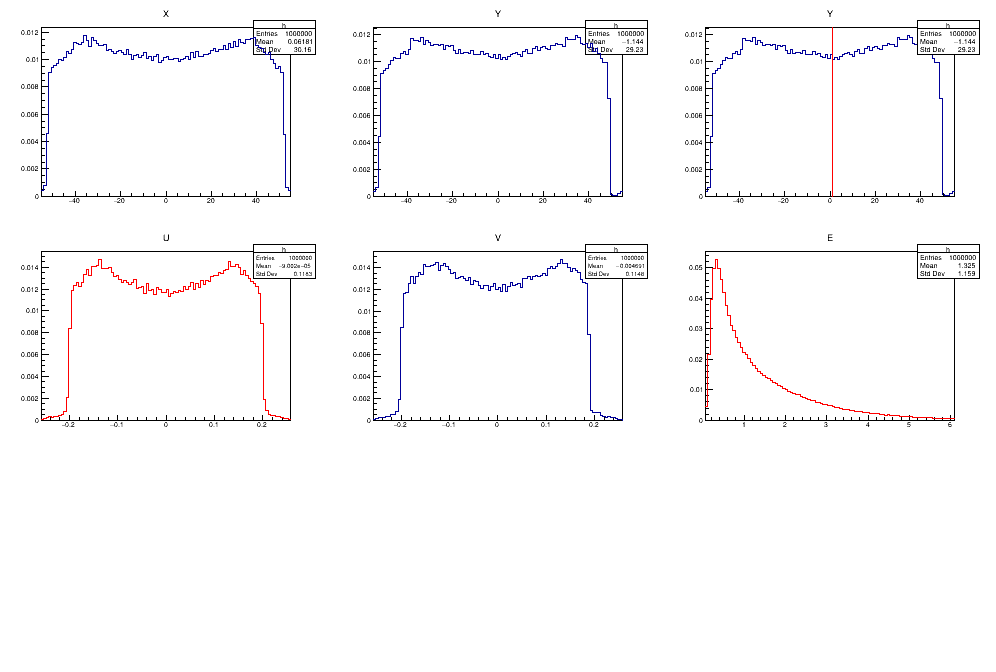

In [ ]:
cs = TCanvas("cs","cs",10,10,1000,700)
cs.Divide(3,3)
cs.cd(1)
histX1.DrawNormalized().SetLineColor(2)
histX2.DrawNormalized("SAME")
cs.cd(2)
histY1.DrawNormalized().SetLineColor(2)
histY2.DrawNormalized("SAME")
cs.cd(3)
histW1.DrawNormalized()
histW2.DrawNormalized("SAME").SetLineColor(2)
cs.cd(4)
histU1.DrawNormalized()
histU2.DrawNormalized("SAME").SetLineColor(2)
cs.cd(5)
histV1.DrawNormalized().SetLineColor(2)
histV2.DrawNormalized("SAME")
cs.cd(6)
histE1.DrawNormalized()
histE2.DrawNormalized("SAME").SetLineColor(2)
cs.Draw()

#Odtwarzanie pozostałej części przestrzeni fazowej

In [ ]:
rand_cor.to_csv("/home/dawid/IAEA/ps.csv")
from iaea.data import get_example_data as get_data
from iaea.utils import convertCsvToIaea
output_file = "/mnt/c/Users/dawid/Desktop/inztekst/ps_do_pracy"
convertCsvToIaea("/home/dawid/IAEA/ps.csv", output_file)

In [ ]:
dane = "/mnt/c/Users/dawid/Desktop/inztekst/ps_do_pracy"
reader = Reader(dane)
stat = 500000
new_data = reader.GetParticles(stat)  # Nowa przestrzeń fazowa

[INFO]:: Total number of particles in file ps_do_pracy.IAEAphsp = 499999
[INFO]:: Number of original histories in header file ps_do_pracy.IAEAphsp = 499999
[INFO]:: The number of Extra Floats is 0 and the number of Extra Ints is 1
[INFO]:: Reading 500000 particles from phsp... (first evt no. = 1)
[INFO]:: 0% particles read-in (evt no. = 1)
[INFO]:: 10% particles read-in (evt no. = 50001)
[INFO]:: 20% particles read-in (evt no. = 100001)
[INFO]:: 30% particles read-in (evt no. = 150001)
[INFO]:: 40% particles read-in (evt no. = 200001)
[INFO]:: 50% particles read-in (evt no. = 250001)
[INFO]:: 60% particles read-in (evt no. = 300001)
[INFO]:: 70% particles read-in (evt no. = 350001)
[INFO]:: 80% particles read-in (evt no. = 400001)
[INFO]:: 90% particles read-in (evt no. = 450001)
[WARNING]:: IaeaReader:: end of PhSp file reached during event 499999


# Porównanie początkowej i wygenerowanej przestrzeni fazowej

In [ ]:
dane = "/mnt/c/Users/dawid/Desktop/CSVtoPHSP/E6.1_s0.5"  
reader = Reader(dane)
stat = 500000
data = reader.GetParticles(stat) #Początkowa przestrzeń fazowa 

[INFO]:: Total number of particles in file E6.1_s0.5.IAEAphsp = 35159414
[INFO]:: Number of original histories in header file E6.1_s0.5.IAEAphsp = 50000000
[INFO]:: The number of Extra Floats is 0 and the number of Extra Ints is 6
[INFO]:: Reading 500000 particles from phsp... (first evt no. = 1)
[INFO]:: 0% particles read-in (evt no. = 1)
[INFO]:: 10% particles read-in (evt no. = 33075)
[INFO]:: 20% particles read-in (evt no. = 66140)
[INFO]:: 30% particles read-in (evt no. = 99315)
[INFO]:: 40% particles read-in (evt no. = 132596)
[INFO]:: 50% particles read-in (evt no. = 165604)
[INFO]:: 60% particles read-in (evt no. = 198792)
[INFO]:: 70% particles read-in (evt no. = 231834)
[INFO]:: 80% particles read-in (evt no. = 264834)
[INFO]:: 90% particles read-in (evt no. = 297966)


In [ ]:
# PRESELEKCJA DANYCH
data = data[data["Particle"]=="gamma"] 
data = data.drop_duplicates(subset=['EvtId'])
data = data[data["Theta"]<15]
data = data[data["X"].between(-50,50)]
data = data[data["Y"].between(-50,50)]
data = data[data["U"].between(-0.2,0.2)]
data = data[data["V"].between(-0.2,0.2)]
#data = data.reset_index()

new_data = new_data[new_data["Particle"]=="gamma"] 
new_data = new_data.drop_duplicates(subset=['EvtId'])
new_data = new_data[new_data["Theta"]<15]
new_data = new_data[new_data["X"].between(-50,50)]
new_data = new_data[new_data["Y"].between(-50,50)]
new_data = new_data[new_data["U"].between(-0.2,0.2)]
new_data = new_data[new_data["V"].between(-0.2,0.2)]
#new_data = new_data.reset_index()


In [ ]:
data.corr(method='spearman').style.background_gradient(cmap='coolwarm').set_precision(4) 

/tmp/ipykernel_1012/1878109499.py:1: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  data.corr(method='spearman').style.background_gradient(cmap='coolwarm').set_precision(4)


,EvtId,X,Y,Z,E,Ekin,Px,Py,Pz,U,V,W,Theta
EvtId,1.0000,0.0005,-0.0010,0.0004,-0.0015,-0.0015,0.0006,-0.0019,-0.0015,-0.0001,-0.0016,0.0011,-0.0011
X,0.0005,1.0000,-0.0034,0.0012,0.0007,0.0007,0.8797,-0.0030,0.0007,0.9860,-0.0031,-0.0004,0.0004
Y,-0.0010,-0.0034,1.0000,0.0601,-0.0007,-0.0007,-0.0036,0.8803,-0.0006,-0.0035,0.9859,0.0121,-0.0122
Z,0.0004,0.0012,0.0601,1.0000,-0.0114,-0.0114,0.0012,0.0378,-0.0117,0.0020,0.0587,-0.0419,0.0419
E,-0.0015,0.0007,-0.0007,-0.0114,1.0000,1.0000,-0.0003,-0.0047,1.0000,0.0006,-0.0004,0.1395,-0.1395
Ekin,-0.0015,0.0007,-0.0007,-0.0114,1.0000,1.0000,-0.0003,-0.0047,1.0000,0.0006,-0.0004,0.1395,-0.1395
Px,0.0006,0.8797,-0.0036,0.0012,-0.0003,-0.0003,1.0000,-0.0045,-0.0003,0.8891,-0.0038,0.0008,-0.0008
Py,-0.0019,-0.0030,0.8803,0.0378,-0.0047,-0.0047,-0.0045,1.0000,-0.0046,-0.0033,0.8901,0.0090,-0.0090
Pz,-0.0015,0.0007,-0.0006,-0.0117,1.0000,1.0000,-0.0003,-0.0046,1.0000,0.0006,-0.0003,0.1470,-0.1470
U,-0.0001,0.9860,-0.0035,0.0020,0.0006,0.0006,0.8891,-0.0033,0.0006,1.0000,-0.0036,0.0001,-0.0001


In [ ]:
data.corr(method='spearman').style.background_gradient(cmap='coolwarm').set_precision(4) 

/tmp/ipykernel_1012/1878109499.py:1: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  data.corr(method='spearman').style.background_gradient(cmap='coolwarm').set_precision(4)


,EvtId,X,Y,Z,E,Ekin,Px,Py,Pz,U,V,W,Theta
EvtId,1.0000,0.0005,-0.0010,0.0004,-0.0015,-0.0015,0.0006,-0.0019,-0.0015,-0.0001,-0.0016,0.0011,-0.0011
X,0.0005,1.0000,-0.0034,0.0012,0.0007,0.0007,0.8797,-0.0030,0.0007,0.9860,-0.0031,-0.0004,0.0004
Y,-0.0010,-0.0034,1.0000,0.0601,-0.0007,-0.0007,-0.0036,0.8803,-0.0006,-0.0035,0.9859,0.0121,-0.0122
Z,0.0004,0.0012,0.0601,1.0000,-0.0114,-0.0114,0.0012,0.0378,-0.0117,0.0020,0.0587,-0.0419,0.0419
E,-0.0015,0.0007,-0.0007,-0.0114,1.0000,1.0000,-0.0003,-0.0047,1.0000,0.0006,-0.0004,0.1395,-0.1395
Ekin,-0.0015,0.0007,-0.0007,-0.0114,1.0000,1.0000,-0.0003,-0.0047,1.0000,0.0006,-0.0004,0.1395,-0.1395
Px,0.0006,0.8797,-0.0036,0.0012,-0.0003,-0.0003,1.0000,-0.0045,-0.0003,0.8891,-0.0038,0.0008,-0.0008
Py,-0.0019,-0.0030,0.8803,0.0378,-0.0047,-0.0047,-0.0045,1.0000,-0.0046,-0.0033,0.8901,0.0090,-0.0090
Pz,-0.0015,0.0007,-0.0006,-0.0117,1.0000,1.0000,-0.0003,-0.0046,1.0000,0.0006,-0.0003,0.1470,-0.1470
U,-0.0001,0.9860,-0.0035,0.0020,0.0006,0.0006,0.8891,-0.0033,0.0006,1.0000,-0.0036,0.0001,-0.0001


In [ ]:
w_orig = np.empty(data["X"].shape[0]) # obliczanie wag do normalizacji wykresów
w_orig.fill(1/data["X"].shape[0])


n_orig = np.empty(new_data["X"].shape[0])
n_orig.fill(1/new_data["X"].shape[0])

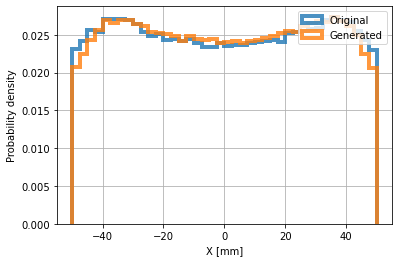

In [ ]:
plt.hist(data['X'], alpha = 0.8, bins =40, weights=w_orig, label ='Original' , histtype='step', linewidth=4)
plt.hist(new_data["X"], alpha =0.8,bins=40, weights=n_orig, label="Generated",  histtype='step', linewidth=4)
plt.xlabel("X [mm]")
plt.ylabel("Probability density")
plt.legend()
plt.grid(True)
plt.show()

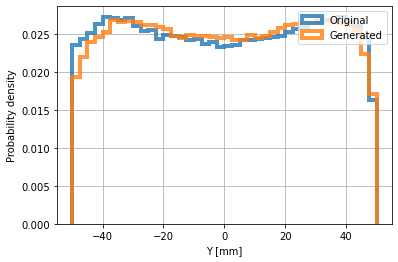

In [ ]:
plt.hist(data['Y'], alpha = 0.8, bins =40, weights=w_orig, label ='Original' , histtype='step', linewidth=4)
plt.hist(new_data["Y"], alpha =0.8,bins=40, weights=n_orig, label="Generated",  histtype='step', linewidth=4)
plt.xlabel("Y [mm]")
plt.ylabel("Probability density")
plt.legend()
plt.grid(True)
plt.show()

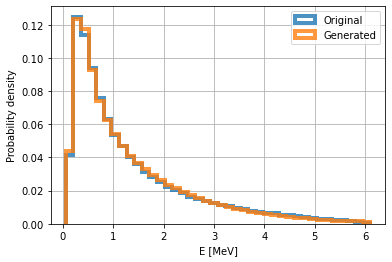

In [ ]:
plt.hist(data['E'], alpha = 0.8, bins =40, weights=w_orig, label ='Original' , histtype='step', linewidth=4)
plt.hist(new_data["E"], alpha =0.8,bins=40, weights=n_orig, label="Generated",  histtype='step', linewidth=4)
plt.xlabel("E [MeV]")
plt.ylabel("Probability density")
plt.legend()
plt.grid(True)
plt.show()

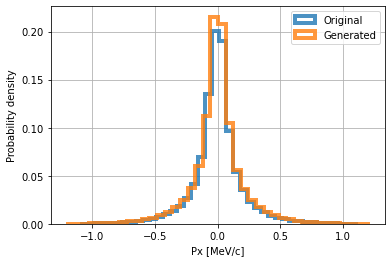

In [ ]:
plt.hist(data['Px'], alpha = 0.8, bins =40, weights=w_orig, label ='Original' , histtype='step', linewidth=4)
plt.hist(new_data["Px"], alpha =0.8,bins=40, weights=n_orig, label="Generated",  histtype='step', linewidth=4)
plt.xlabel("Px [MeV/c]")
plt.ylabel("Probability density")
plt.legend()
plt.grid(True)
plt.show()

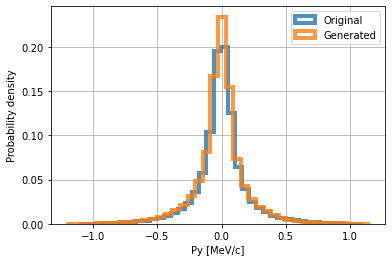

In [ ]:
plt.hist(data['Py'], alpha = 0.8, bins =40, weights=w_orig, label ='Original' , histtype='step', linewidth=4)
plt.hist(new_data["Py"], alpha =0.8,bins=40, weights=n_orig, label="Generated",  histtype='step', linewidth=4)
plt.xlabel("Py [MeV/c]")
plt.ylabel("Probability density")
plt.legend()
plt.grid(True)
plt.show()

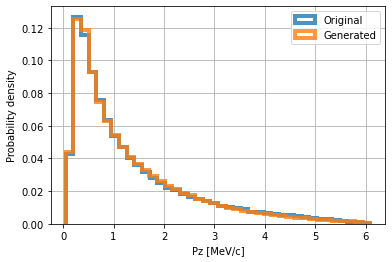

In [ ]:
plt.hist(data['Pz'], alpha = 0.8, bins =40, weights=w_orig, label ='Original' , histtype='step', linewidth=4)
plt.hist(new_data["Pz"], alpha =0.8,bins=40, weights=n_orig, label="Generated",  histtype='step', linewidth=4)
plt.xlabel("Pz [MeV/c]")
plt.ylabel("Probability density")
plt.legend()
plt.grid(True)
plt.show()

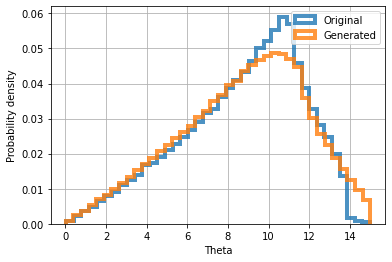

In [ ]:
plt.hist(data['Theta'], alpha = 0.8, bins =40, weights=w_orig, label ='Original' , histtype='step', linewidth=4)
plt.hist(new_data["Theta"], alpha =0.8,bins=40, weights=n_orig, label="Generated",  histtype='step', linewidth=4)
plt.xlabel("Theta")
plt.ylabel("Probability density")
plt.legend()
plt.grid(True)
plt.show()

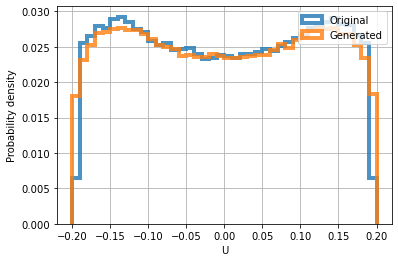

In [ ]:
plt.hist(data['U'], alpha = 0.8, bins =40, weights=w_orig, label ='Original' , histtype='step', linewidth=4)
plt.hist(new_data["U"], alpha =0.8,bins=40, weights=n_orig, label="Generated",  histtype='step', linewidth=4)
plt.xlabel("U")
plt.ylabel("Probability density")
plt.legend()
plt.grid(True)
plt.show()

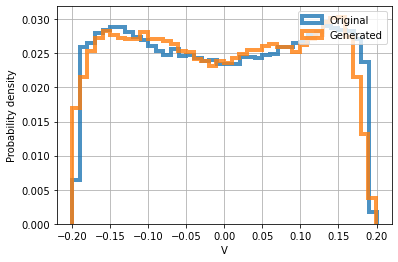

In [ ]:
plt.hist(data['V'], alpha = 0.8, bins =40, weights=w_orig, label ='Original' , histtype='step', linewidth=4)
plt.hist(new_data["V"], alpha =0.8,bins=40, weights=n_orig, label="Generated",  histtype='step', linewidth=4)
plt.xlabel("V")
plt.ylabel("Probability density")
plt.legend()
plt.grid(True)
plt.show()

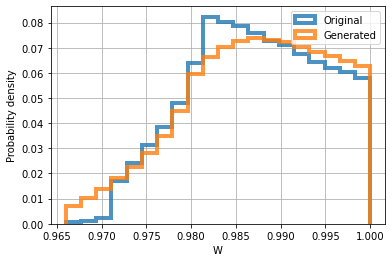

In [ ]:
plt.hist(data['W'], alpha = 0.8, bins =20, weights=w_orig, label ='Original' , histtype='step', linewidth=4)
plt.hist(new_data["W"], alpha =0.8,bins=20, weights=n_orig, label="Generated",  histtype='step', linewidth=4)
plt.xlabel("W")
plt.ylabel("Probability density")
plt.legend()
plt.grid(True)
plt.show()

# Porównanie poszczególnych zmiennych


[Text(0.5, 1.0, 'Początkowy rozkład X i Px')]

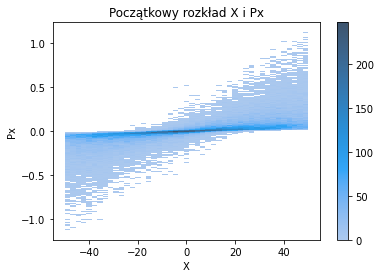

In [ ]:
sns.histplot( data ,x='X',y='Px',cbar=True).set(title ='Początkowy rozkład X i Px')

[Text(0.5, 1.0, 'Rozkład po transformacji X i Px')]

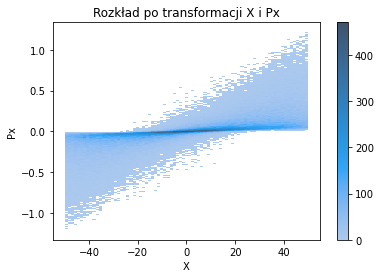

In [ ]:
sns.histplot( new_data ,x='X',y='Px',cbar=True).set(title ='Rozkład po transformacji X i Px')

[Text(0.5, 1.0, 'Początkowy rozkład E i Pz')]

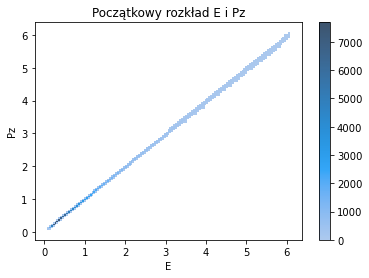

In [ ]:
sns.histplot( data ,x='E',y='Pz',cbar=True).set(title ='Początkowy rozkład E i Pz')

[Text(0.5, 1.0, 'Rozkład po transformacji E i Pz')]

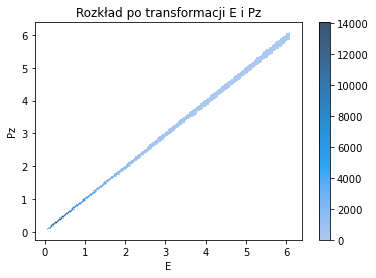

In [ ]:
sns.histplot( new_data ,x='E',y='Pz',cbar=True).set(title ='Rozkład po transformacji E i Pz')

[Text(0.5, 1.0, 'Początkowy rozkład Px i E')]

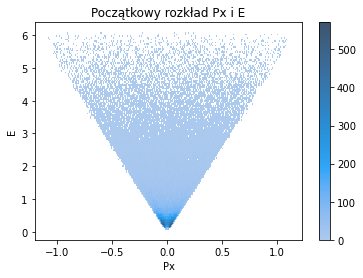

In [ ]:
sns.histplot( data ,x='Px',y='E',cbar=True).set(title ='Początkowy rozkład Px i E')

[Text(0.5, 1.0, 'Rozkład po transformacji Px i E')]

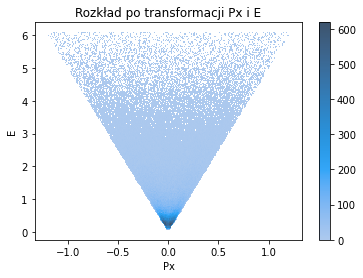

In [ ]:
sns.histplot( new_data ,x='Px',y='E',cbar=True).set(title ='Rozkład po Px i E')

[Text(0.5, 1.0, 'Początkowy rozkład X i U')]

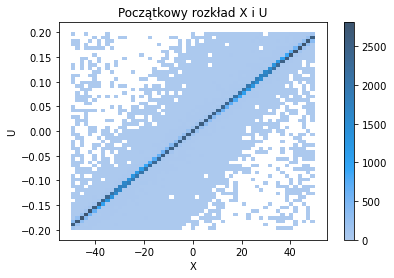

In [ ]:
sns.histplot( data ,x='X',y='U',cbar=True).set(title ='Początkowy rozkład X i U')

[Text(0.5, 1.0, 'Rozkład po X i U')]

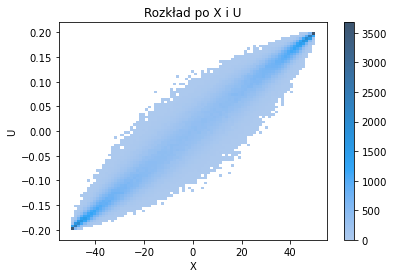

In [ ]:
sns.histplot( new_data ,x='X',y='U',cbar=True).set(title ='Rozkład po  transformacji X i U')

[Text(0.5, 1.0, 'Początkowy rozkład X i Theta')]

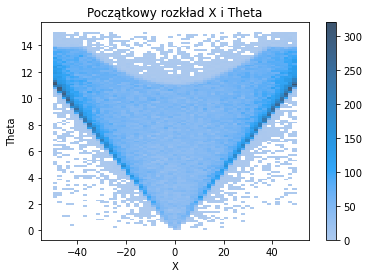

In [ ]:
sns.histplot( data ,x='X',y='Theta',cbar=True).set(title ='Początkowy rozkład X i Theta')

[Text(0.5, 1.0, 'Rozkład po transformacji X i Theta')]

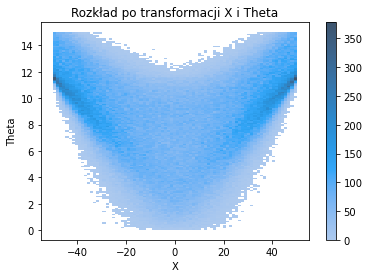

In [ ]:
sns.histplot( new_data ,x='X',y='Theta',cbar=True).set(title ='Rozkład po transformacji X i Theta')

#Porównanie histogramów początkowych i końcowych (czerwone to poczatkowe)

[Text(0.5, 1.0, 'Rozkład początkowy X i Theta')]

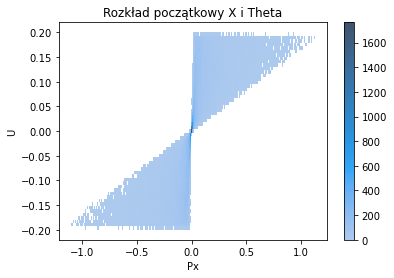

In [ ]:
sns.histplot( data ,x='Px',y='U',cbar=True).set(title ='Rozkład początkowy Px i U')

[Text(0.5, 1.0, 'Rozkład po transformacji Px i U')]

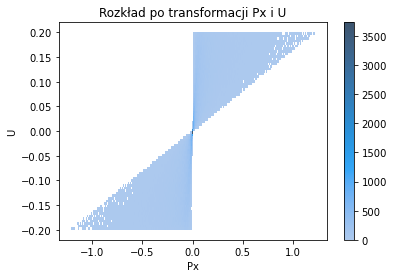

In [ ]:
sns.histplot( new_data ,x='Px',y='U',cbar=True).set(title ='Rozkład po transformacji Px i U')